In [181]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [27]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

In [28]:
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

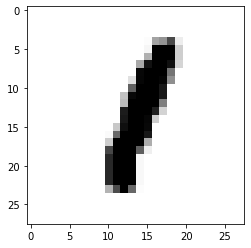

In [65]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [66]:
print(imagens[0].shape) # para vermos as dimensões dos tensores imagens
print(etiquetas[0].shape) # para vermos as dimensões dos tensores etiquetas

torch.Size([1, 28, 28])
torch.Size([])


In [88]:
print(imagens[0])
print(etiquetas[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [134]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saida não e necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self,X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída
        return F.log_softmax(X, dim=1) # dado utilizado para calcular a perda
 


In [135]:
def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a polítca de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 30 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo
    j = 0
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para  "vetores" de 28*28 casas para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
        
        
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [150]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens,etiquetas in valloader:
      for i in range(len(etiquetas)):
        img = imagens[i].view(1, 784)
        # desativar o gradiente para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
        with torch.no_grad():
            logps = modelo(img.to(device)) # output do modelo em escala logaritmica

        
        ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto 
        etiqueta_certa = etiquetas.numpy()[i] 
        if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
          conta_corretas += 1
        conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [163]:
def visualiza_pred(img, ps):

    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Palpite')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [177]:
modelo = Modelo() # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível
modelo.to(device) 



Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [185]:
treino(modelo, trainloader, device)

Epoch 1 - Perda resultante: 1.1615219296677026
Epoch 2 - Perda resultante: 0.38018943163663593
Epoch 3 - Perda resultante: 0.310409199645016
Epoch 4 - Perda resultante: 0.2705956547896364
Epoch 5 - Perda resultante: 0.24003243423315254
Epoch 6 - Perda resultante: 0.21413177627919197
Epoch 7 - Perda resultante: 0.19253126921445957
Epoch 8 - Perda resultante: 0.17489495359933072
Epoch 9 - Perda resultante: 0.15927938855628468
Epoch 10 - Perda resultante: 0.1463910402940598
Epoch 11 - Perda resultante: 0.13529382343056487
Epoch 12 - Perda resultante: 0.12483722554134534
Epoch 13 - Perda resultante: 0.11651990410965135
Epoch 14 - Perda resultante: 0.10852656765247205
Epoch 15 - Perda resultante: 0.1015510213678516
Epoch 16 - Perda resultante: 0.09513922434832368
Epoch 17 - Perda resultante: 0.08896013902528073
Epoch 18 - Perda resultante: 0.08409812069460273
Epoch 19 - Perda resultante: 0.07953526273067953
Epoch 20 - Perda resultante: 0.07515604874250223
Epoch 21 - Perda resultante: 0.0713

In [186]:
validacao(modelo, valloader, device)

Total de imagens testadas = 10000

Precisão do modelo = 97.57%


Número previsto = 6


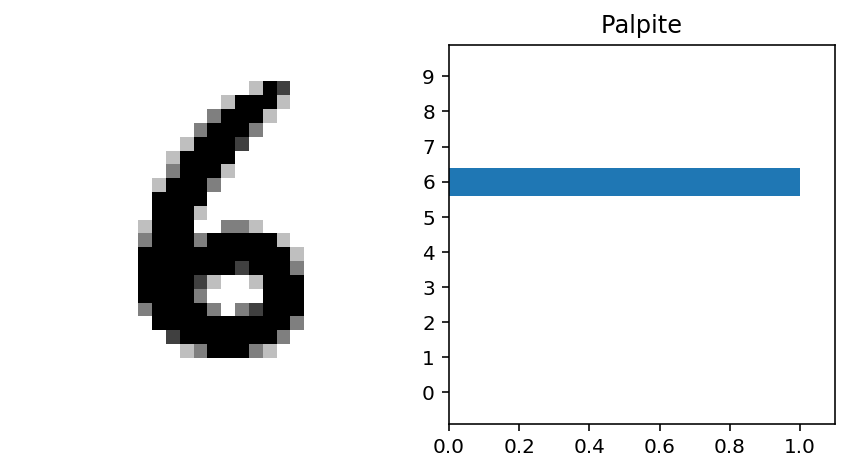

In [193]:
imagens, etiquetas = next(iter(valloader))

img = imagens[0].view(1, 784)
with torch.no_grad():
    logps = modelo(img.to(device))

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Número previsto =", probab.index(max(probab)))
visualiza_pred(img.view(1, 28, 28), ps)

In [180]:
torch.save(modelo.state_dict(), './meu_modelo.pt') # para salvar o modelo

# para carregar o modelo
modelo_carregado = Modelo()

modelo_carregado.load_state_dict(torch.load('./meu_modelo.pt'))
modelo_carregado.eval()
modelo_carregado.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)